In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import pickle
from time import time

from consav import linear_interp

import LimitedCommitmentModel as lcm

# plot style
linestyles = ['-','--','-.',':',':','-','-.']
markers = ['o','s','D','*','P','o','s']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
do_egm = True
threads = 50

# from EconModel import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print=True)

In [2]:
# compile c++ files
if do_cpp & do_compile:
    model = lcm.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)
    model.cpp.delink()

# Solve and simulate from alternative models

Benchmark model settings

In [3]:
settings = { 
       'T':20,
       'p_meet': 0.1, 
       'div_A_share': 0.5, 
       'sigma_love':0.1,
       'do_cpp':do_cpp,
       'threads':threads, 
       'interp_power':False,
       'num_love': 21, 
       'do_egm':True, 
       'num_A': 50, 
       'num_A_pd':50,
       'num_Ctot':50,
       'simT':20,
       'simN': 10000,
       'centered_gradient':True,
       'use_external_solution':True,
       }

Detailed (true) model

In [4]:
solution_specs = {'solution': {'latexname':'Solution', 'par':{**settings, 'do_egm':False, 'num_A': 250, 'num_Ctot':250, 'num_power':101, 'num_love':101}}}

Models

In [5]:
num_margu = 15

specs = {
    'model 1':{'latexname':'VFI', 'par':{**settings, 'use_external_solution':True, 'do_egm':False}},
    'model 2':{'latexname':f'iEGM c{num_margu} linear', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':num_margu}},
    'model 3':{'latexname':'iEGM c100 linear', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':100}},
    # 'model 4':{'latexname':f'iEGM c{num_margu}, linear inverse', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':num_margu, 'interp_inverse': True}},
    # 'model 5':{'latexname':'iEGM c100 linear inverse', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':100, 'interp_inverse': True}},
    # 'model 6':{'latexname':'iEGM numerical inverse', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':100, 'interp_method': "numerical"}},
    # 'model 7':{'latexname':'iEGM numerical inverse, interpolate', 'par':{**settings, 'use_external_solution':True, 'interp_intra_period_in_num_inverse':True, 'num_marg_u':100, 'interp_method': "numerical"}},
    }

## Solve

Solve detailed (true) model

In [6]:
# solve/load solution Marginal values
do_load = False
do_save = True
do_solve = True

if do_solve:
    model_solution = lcm.HouseholdModelClass(par=solution_specs['solution']['par'])

    print('Linking to c++')
    model_solution.link_to_cpp(force_compile=False)

    print('Solving solution model')
    %time model_solution.solve()
    model_solution.cpp.compute_margEV(model_solution.sol,model_solution.par)

    EmargV_start_as_couple_true = model_solution.sol.EmargV_start_as_couple
    EmargVw_start_as_single_true = model_solution.sol.EmargVw_start_as_single
    EmargVm_start_as_single_true = model_solution.sol.EmargVm_start_as_single
    grid_A_true = model_solution.par.grid_A
    grid_power_true = model_solution.par.grid_power
    grid_love_true = model_solution.par.grid_love

    margV_list = [EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true]

    ## saveobject in pickle
    if do_save:
        with open('output/solution_margV.pkl', 'wb') as f:
            pickle.dump(margV_list, f)
        print('Saved solution margVs')

if do_load:
    with open('output/solution_margV.pkl', 'rb') as f:
        EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true = pickle.load(f)
    print('Loaded solution margVs')


Linking to c++
Solving solution model
CPU times: total: 1h 8min 17s
Wall time: 1min 49s
Saved solution margVs


Solve models

In [7]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'\nsolving {spec["latexname"]}...')
    
    # setup model
    models[name] = lcm.HouseholdModelClass(name=name,par=spec['par'])
    models[name].par.seed = 0
    models[name].allocate()

    if models[name].par.use_external_solution:
        print("Set external solution for computing Euler Errors")
        models[name].set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)

        
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec

    # # solve
    %time models[name].solve()

    # simulate
    print(f'Simulating {spec["latexname"]}...')
    %time models[name].simulate()
    print(f'Mean log10 euler error: {models[name].sim.mean_log10_euler}')




solving VFI...
Set external solution for computing Euler Errors
CPU times: total: 32 s
Wall time: 1.95 s
Simulating VFI...
CPU times: total: 16min
Wall time: 22.2 s
Mean log10 euler error: [-5.56573079]

solving iEGM c15 linear...
Set external solution for computing Euler Errors
CPU times: total: 6.23 s
Wall time: 162 ms
Simulating iEGM c15 linear...
CPU times: total: 5min 38s
Wall time: 7.61 s
Mean log10 euler error: [-1.08007057]

solving iEGM c100 linear...
Set external solution for computing Euler Errors
CPU times: total: 5.53 s
Wall time: 173 ms
Simulating iEGM c100 linear...
CPU times: total: 16min 1s
Wall time: 21.6 s
Mean log10 euler error: [-5.42954542]


## Plots

Couple consumption

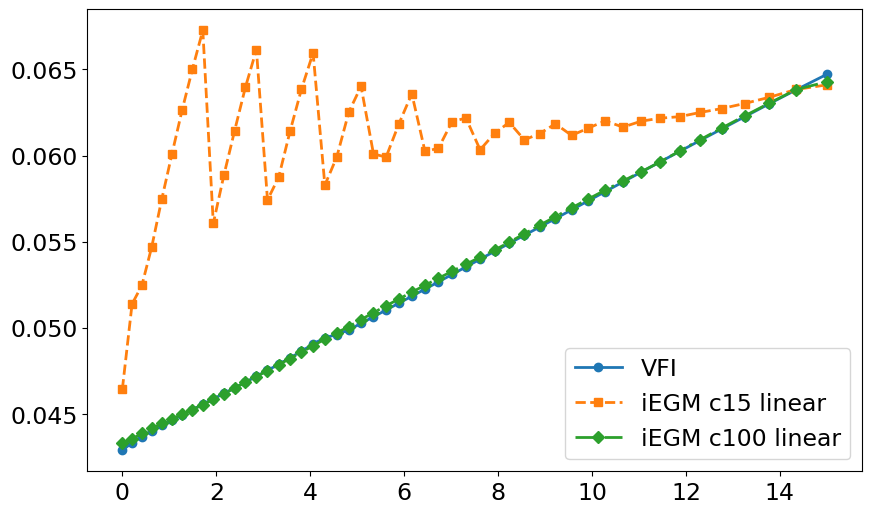

In [8]:
# plot model solutions
grid = 'grid_A'
var = 'power_idx'
var = 'Cw_priv_couple_to_couple'
#var = 'Cw_priv_single_to_couple'

t = 0
iP = 2
iL = 1
iA = 21

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 0
for name, model in models.items():
    
    par = model.par
    sol = model.sol

    ax.plot(getattr(par,grid), getattr(sol,var)[t,iP,iL], label=model.spec['latexname'], linestyle=linestyles[i], marker=markers[i], linewidth=linewidth)
    i += 1
ax.legend()


Single consumption

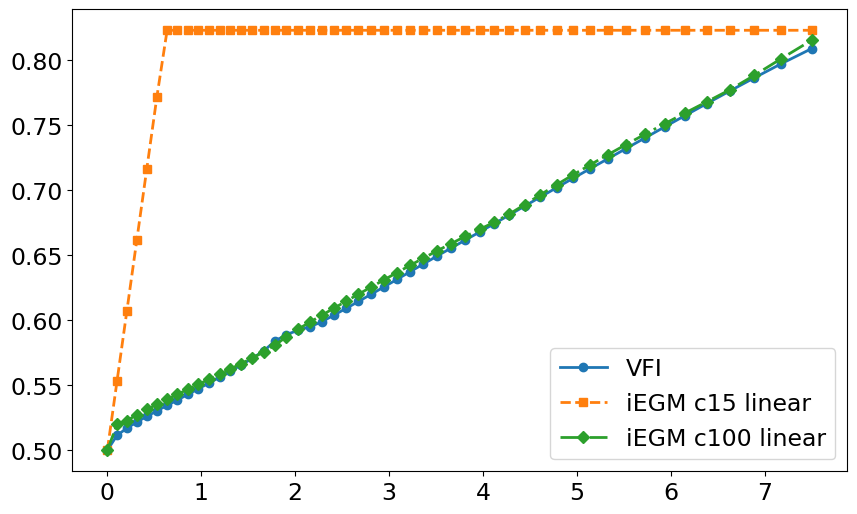

In [9]:
# plot model solutions
grid = 'grid_Aw'
var = 'Cw_priv_single_to_single'

t = 4

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 0
for name, model in models.items():
    
    par = model.par
    sol = model.sol

    ax.plot(getattr(par,grid), getattr(sol,var)[t], label=model.spec['latexname'], linestyle=linestyles[i], marker=markers[i], linewidth=linewidth)
    i += 1
ax.legend()

What is this???

In [10]:
# # Re-compile and solve
# for model in models.values():
#     model.cpp.delink()

# recompile = True
# for name in models.keys():
#     models[name].link_to_cpp(force_compile=recompile)

#     print(f'\nsolving {name}...')
#     models[name].allocate()
#     %time models[name].solve()
    
#     recompile = False


## Monte Carlo runs

Monte Carlo settings

In [11]:
MC_num = 200 # number of Monte Carlo simulations
C_num_grid = (20,50,100,200) # number of grid points in consumption grid i iEGM
PRINT = True

Set up containers

In [25]:
timing = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm': np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
error = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm': np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
for i_c,num_C in enumerate(C_num_grid):
    timing['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)

Run monte carlo simulations

In [15]:
for i_mc in range(188,MC_num):
    if PRINT: print(f'{i_mc+1}/{MC_num} running...')

    # simulate true model (solved once above)
    model_true.par.seed = i_mc
    model_true.allocate_draws()
    model_true.simulate()
    true_mean_lifetime_util = model_true.sim.mean_lifetime_util

    # setup alternative model solutios
    model = lcm.HouseholdModelClass(par=settings)

    model.par.seed = i_mc
    model.allocate()
    model.set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)

    model.link_to_cpp(force_compile=False)

    # VFI
    model.par.do_egm = False
    
    # Timing
    t0 = time()
    model.solve()
    timing['vfi'][i_mc] = time() - t0

    # Euler error
    model.simulate()
    error['vfi'][i_mc] = model.sim.mean_log10_euler

    # iEGM
    model.par.do_egm = True
    for interp_inverse in (False,True):
        model.par.interp_inverse = interp_inverse
        method = f'iegm, linear inverse' if interp_inverse else 'iegm, linear'
        for i_c,num_C in enumerate(C_num_grid):
            model.par.num_marg_u = num_C

            model.allocate()
            model.set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)

            # Timing
            t0 = time()
            model.solve()
            timing[method][num_C][i_mc] = time() - t0

            # Euler error
            model.simulate()
            error[method][num_C][i_mc] = model.sim.mean_log10_euler
            
    model.cpp.delink()

    # save MC objects
    with open('output/MC_timing.pkl', 'wb') as f:
        pickle.dump(timing, f)
    with open('output/MC_error.pkl', 'wb') as f:
        pickle.dump(error, f)

189/200 running...
190/200 running...
191/200 running...
192/200 running...
193/200 running...
194/200 running...
195/200 running...
196/200 running...
197/200 running...
198/200 running...
199/200 running...
200/200 running...


Results

In [16]:
print('Euler Error & Timing (rel. to VFI)')
timing_vfi = np.mean(timing['vfi'])
for method in ('vfi',):
    error_now = np.nanmean(error[method])
    time_now = np.nanmean(timing[method]) / timing_vfi
    print(f'{method}: {error_now:2.3f} & {time_now:2.3f} ')

for method in ('iegm, linear','iegm, linear inverse'):
    print(f'{method}: ')
    for i_c,num_C in enumerate(C_num_grid):
        error_now = np.nanmean(error[method][num_C]) 
        time_now = np.nanmean(timing[method][num_C]) / timing_vfi
        print(f'{num_C:d} {error_now:2.3f} & {time_now:2.3f} ')

Euler Error & Timing (rel. to VFI)
vfi: -5.565 & 1.000 
iegm, linear: 
20 -2.324 & 0.111 
50 -4.538 & 0.107 
100 -5.436 & 0.117 
200 -5.506 & 0.133 
iegm, linear inverse: 
20 -3.968 & 0.111 
50 -5.772 & 0.110 
100 -5.504 & 0.116 
200 -5.394 & 0.135 
